In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [77]:
# Load in data
data = pd.read_csv('../data/investigation_train_large_checked.csv')

# Check how data looks like (first 5 rows)
print(data.head())

   adres_aantal_brp_adres  adres_aantal_verschillende_wijken  \
0                       1                                  1   
1                       4                                  2   
2                       6                                  4   
3                       3                                  2   
4                       3                                  2   

   adres_aantal_verzendadres  adres_aantal_woonadres_handmatig  \
0                          0                                 0   
1                          1                                 1   
2                          2                                 1   
3                          0                                 1   
4                          0                                 0   

   adres_dagen_op_adres  adres_recentst_onderdeel_rdam  \
0                 23240                              1   
1                  1971                              1   
2                  7247                     

In [78]:
# Check the features/columns
chunk_size = 10  # Number of column names per group
columns = data.columns.tolist()

# print in groups for better overview
for i in range(0, len(columns), chunk_size):
    print(columns[i:i + chunk_size])

['adres_aantal_brp_adres', 'adres_aantal_verschillende_wijken', 'adres_aantal_verzendadres', 'adres_aantal_woonadres_handmatig', 'adres_dagen_op_adres', 'adres_recentst_onderdeel_rdam', 'adres_recentste_buurt_groot_ijsselmonde', 'adres_recentste_buurt_nieuwe_westen', 'adres_recentste_buurt_other', 'adres_recentste_buurt_oude_noorden']
['adres_recentste_buurt_vreewijk', 'adres_recentste_plaats_other', 'adres_recentste_plaats_rotterdam', 'adres_recentste_wijk_charlois', 'adres_recentste_wijk_delfshaven', 'adres_recentste_wijk_feijenoord', 'adres_recentste_wijk_ijsselmonde', 'adres_recentste_wijk_kralingen_c', 'adres_recentste_wijk_noord', 'adres_recentste_wijk_other']
['adres_recentste_wijk_prins_alexa', 'adres_recentste_wijk_stadscentru', 'adres_unieke_wijk_ratio', 'afspraak_aanmelding_afgesloten', 'afspraak_aantal_woorden', 'afspraak_afgelopen_jaar_afsprakenplan', 'afspraak_afgelopen_jaar_monitoring_insp__wet_taaleis_na_12_mnd_n_a_v__taa04_____geen_maatregel', 'afspraak_afgelopen_jaar_

In [79]:
# check columns ja nee checked
print(data['Ja'])
print(data['Nee'])
print(data['checked'])

0         0.617698
1         0.602167
2         0.512377
3         0.717796
4         0.705484
            ...   
129995    0.627435
129996    0.623105
129997    0.630888
129998    0.478608
129999    0.526215
Name: Ja, Length: 130000, dtype: float64
0         0.382302
1         0.397833
2         0.487623
3         0.282204
4         0.294516
            ...   
129995    0.372565
129996    0.376895
129997    0.369112
129998    0.521392
129999    0.473785
Name: Nee, Length: 130000, dtype: float64
0         False
1         False
2         False
3          True
4          True
          ...  
129995    False
129996    False
129997    False
129998    False
129999    False
Name: checked, Length: 130000, dtype: bool


In [80]:
# load in data description
data_desc = pd.read_csv('../data/data_description.csv')

# sort on high to low importance
data_desc_sorted = data_desc.sort_values(by='Relative importance', ascending=False)
print(data_desc_sorted)


      ID                                   Feature (nl)  \
216  217                 persoon_leeftijd_bij_onderzoek   
290  291       relatie_overig_actueel_vorm__kostendeler   
140  141                    contacten_onderwerp_no_show   
90    91         competentie_vakdeskundigheid_toepassen   
142  143        contacten_onderwerp_overleg_met_inkomen   
..   ...                                            ...   
123  124        contacten_onderwerp_boolean_uitnodiging   
122  123            contacten_onderwerp_boolean_traject   
121  122    contacten_onderwerp_boolean_terugbelverzoek   
120  121  contacten_onderwerp_boolean_taaleis___voldoet   
314  315            typering_zorg__schoonmaak___welzijn   

                                          Feature (en) Datatype  \
216                        person_age_at_investigation      int   
290        relationship_other_current_form_cost_sharer      int   
140                           contacts_subject_no_show      int   
90                     

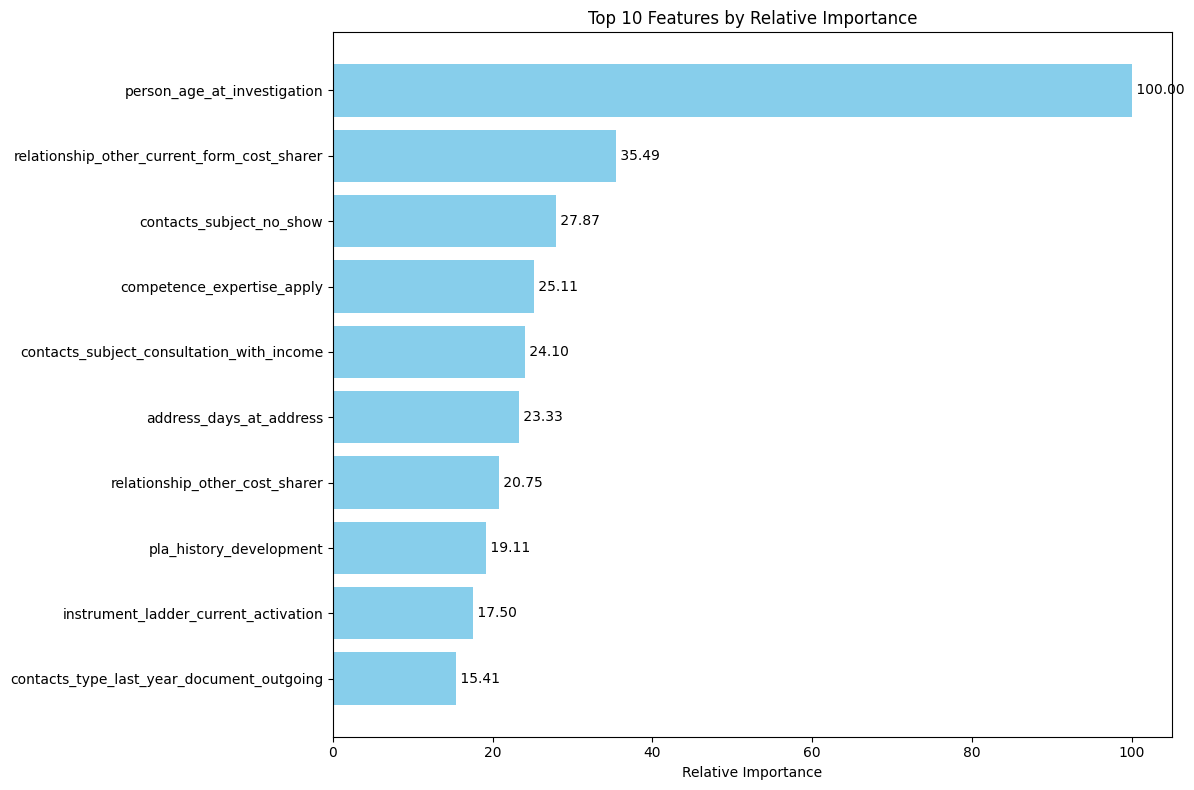

In [81]:
# visualise data description with imporant weight in histogram
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Select the top 10 features
top_10 = data_desc_sorted.head(10)
# For better visualization, reverse the DataFrame to have the highest importance at the top
top_10 = top_10[::-1]

# Set the figure size for better readability
plt.figure(figsize=(12, 8))

# Create a horizontal bar chart
plt.barh(top_10['Feature (en)'], top_10['Relative importance'], color='skyblue')

# Add labels and title
plt.xlabel('Relative Importance')
plt.title('Top 10 Features by Relative Importance')

# Display the values on the bars
for index, value in enumerate(top_10['Relative importance']):
    plt.text(value, index, f' {value:.2f}', va='center')

# Show the plot
plt.tight_layout()
plt.show()


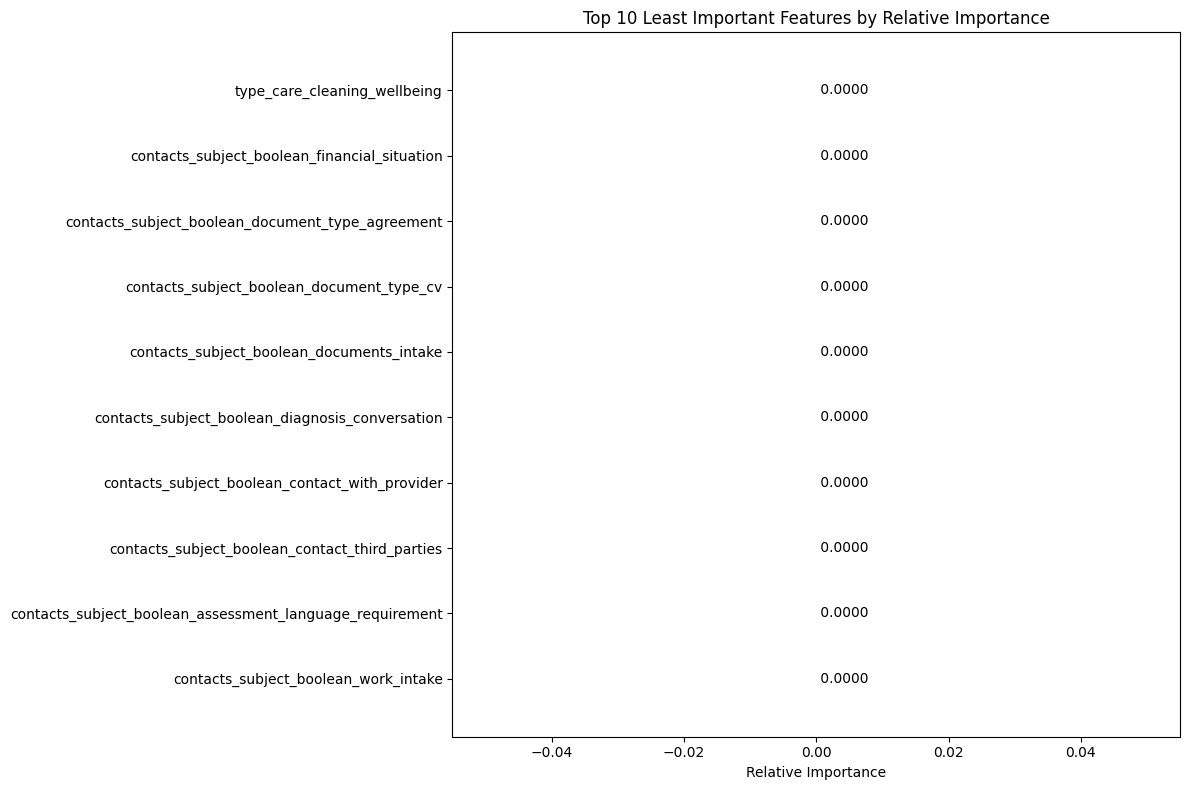

In [89]:
# now the same top 10 lowest importance features
# Step 1: Load the data
data_desc = pd.read_csv('../data/data_description.csv')

# Step 2: Sort the data by 'Relative importance' in ascending order
data_desc_sorted_low = data_desc.sort_values(by='Relative importance', ascending=True)

# Step 3: Select the bottom 10 features
bottom_10 = data_desc_sorted_low.head(10)

# Step 4: Create a horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(bottom_10['Feature (en)'][::-1], bottom_10['Relative importance'][::-1], color='lightcoral')
plt.xlabel('Relative Importance')
plt.title('Top 10 Least Important Features by Relative Importance')

# Add values on the bars
for index, value in enumerate(bottom_10['Relative importance'][::-1]):
    plt.text(value, index, f' {value:.4f}', va='center')

plt.tight_layout()
plt.show()
